# Diagnose pairwise scorer vs clustering bottleneck (SciCo)

This notebook loads dumped pairwise logits (`pair_scores_*.jsonl`) and computes PR curves, AUPRC, and bridge/impurity diagnostics at a chosen probability threshold `tau`.

It is intended to answer: **Is the clustering step amplifying a small FP rate, or is the pairwise scorer not precise enough at the operating point?**


In [1]:
import json, os
import numpy as np
from datasets import load_dataset
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

def load_pair_scores(path):
    by_tid = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            by_tid[int(obj['topic_id'])] = obj
    return by_tid

class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.size = [1]*n
    def find(self, x):
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x
    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb: return
        if self.size[ra] < self.size[rb]:
            ra, rb = rb, ra
        self.parent[rb] = ra
        self.size[ra] += self.size[rb]
    def components(self):
        comps = {}
        for i in range(len(self.parent)):
            r = self.find(i)
            comps.setdefault(r, []).append(i)
        return comps


## Configure inputs

Set the paths to your dumped scores and temperature JSON, and choose a threshold `tau` (probability cutoff).

Tip: If your sweep used a **distance threshold** `t` with `tau = 1 - t`, convert it here.


In [ ]:
scores_path = 'output/output_neg30/pair_scores_dev.jsonl'  # TODO
split = 'validation'
temperature_json = 'output/output_neg30/temperature_dev.json'  # TODO (or None)

# Choose the probability threshold you want to diagnose (e.g., CoNLL-optimal tau)
tau = 0.9  # TODO

T = 1.0
if temperature_json and os.path.exists(temperature_json):
    with open(temperature_json, 'r', encoding='utf-8') as f:
        T = float(json.load(f)['temperature'])
print('Temperature T =', T)


Temperature T = 1.0


## Load SciCo + dumped pair scores and build global arrays


In [54]:
ds = load_dataset('allenai/scico')[split]
by_id = {int(r['id']): r for r in ds}

scores_by_tid = load_pair_scores(scores_path)
topic_ids = sorted(scores_by_tid.keys())

all_probs = []
all_y = []

per_topic = []

for tid in topic_ids:
    obj = scores_by_tid[tid]
    n = int(obj['n'])
    edges = obj['edges']
    row = by_id.get(tid)
    if row is None: continue
    if len(row['mentions']) != n: continue
    gold_cids = [int(m[3]) for m in row['mentions']]

    logits = np.array([float(e['logit']) for e in edges], dtype=np.float32)
    probs = sigmoid(logits / T)
    y = np.array([1 if gold_cids[int(e['i'])] == gold_cids[int(e['j'])] else 0 for e in edges], dtype=np.int8)

    all_probs.append(probs)
    all_y.append(y)
    per_topic.append({'topic_id': tid, 'n_mentions': n, 'n_edges': len(edges), 'pos_rate_edges': float(y.mean()) if len(y) else 0.0})

probs_all = np.concatenate(all_probs)
y_all = np.concatenate(all_y)
print('Total pairs:', len(y_all), 'pos_rate=', float(y_all.mean()))


Total pairs: 124579 pos_rate= 0.14061760007705953


## Global PR curve / AUPRC on the **true all-pairs** distribution


AUPRC = 0.7303030688260306


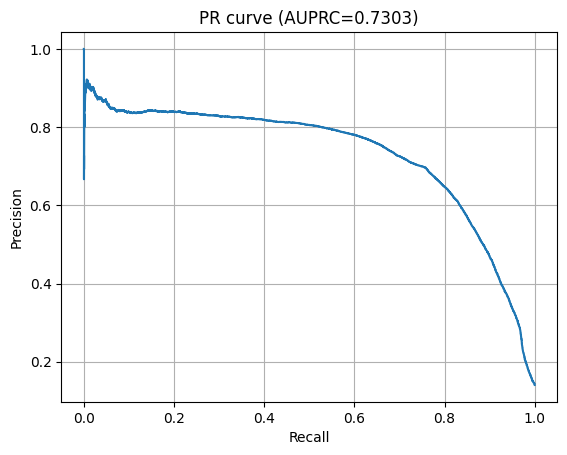

In [55]:
prec, rec, thr = precision_recall_curve(y_all, probs_all)
auprc = average_precision_score(y_all, probs_all)
print('AUPRC =', auprc)

plt.figure()
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR curve (AUPRC={auprc:.4f})')
plt.grid(True)
plt.show()


## Metrics at a chosen threshold `tau` (full pairs)


In [56]:
pred = (probs_all >= tau).astype(np.int8)
P = precision_score(y_all, pred, zero_division=0)
R = recall_score(y_all, pred, zero_division=0)
F = f1_score(y_all, pred, zero_division=0)

TP = int(((pred==1) & (y_all==1)).sum())
FP = int(((pred==1) & (y_all==0)).sum())
kept = int(pred.sum())

print(f'tau={tau:.3f} kept={kept} TP={TP} FP={FP}  precision={P:.4f} recall={R:.4f} F1={F:.4f}')


tau=0.900 kept=13180 TP=10322 FP=2858  precision=0.7832 recall=0.5892 F1=0.6725


## Bridge/impurity diagnostics at `tau`

We build the graph of edges with p>=tau, take connected components, and check how often a predicted component mixes multiple gold clusters.


In [57]:
impure_components_total = 0
merged_gold_total = 0
frac_mentions_in_impure = []
max_impure_size = 0

for tid in topic_ids:
    obj = scores_by_tid[tid]
    n = int(obj['n'])
    edges = obj['edges']
    row = by_id.get(tid)
    if row is None: continue
    if len(row['mentions']) != n: continue
    gold_cids = [int(m[3]) for m in row['mentions']]

    logits = np.array([float(e['logit']) for e in edges], dtype=np.float32)
    probs = sigmoid(logits / T)
    keep = probs >= tau

    uf = UnionFind(n)
    for k, e in enumerate(edges):
        if not keep[k]:
            continue
        uf.union(int(e['i']), int(e['j']))

    comps = uf.components()
    impure = 0
    mentions_impure = 0
    for nodes in comps.values():
        cset = {gold_cids[i] for i in nodes}
        if len(cset) > 1:
            impure += 1
            mentions_impure += len(nodes)
            merged_gold_total += (len(cset) - 1)
            max_impure_size = max(max_impure_size, len(nodes))
    impure_components_total += impure
    frac_mentions_in_impure.append(mentions_impure / n if n else 0.0)

print('total impure components:', impure_components_total)
print('approx merged gold clusters total:', merged_gold_total)
print('mean frac mentions in impure components:', float(np.mean(frac_mentions_in_impure)))
print('max impure component size:', max_impure_size)


total impure components: 188
approx merged gold clusters total: 411
mean frac mentions in impure components: 0.42714027568373547
max impure component size: 42


If `mean frac mentions in impure components` is non-trivial, you are in the regime where even a small FP rate is creating over-merges (which usually correlates with low CEAF-E/B³). In that case, you either need much higher edge precision at the operating point, or a decoder that is far more conservative (mutual top-k, veto rules), or a different training objective (antecedent ranking / cluster-aware).